## Finding Your Way In The City (Graph Edition)
In this notebook your attention will shift from grids to graphs. At least for search ... 

Using Voronoi graphs and the medial axis transform we can find paths which maximize safety from obstacles. In addition, graph representation allows further optimizations and more succinct queries.

In [1]:
# OK this might look a little ugly but...
# need to import the latest version of networkx
# This occassionally fails, so if the next cell 
# doesn't show that you're using networkx 2.1
# please "restart and clear output" from "Kernel" menu
# above and try again.
import sys
!{sys.executable} -m pip install -I networkx==2.1
# import pkg_resources
# pkg_resources.require("networkx==2.1")

Processing /Users/michaelrose/Library/Caches/pip/wheels/73/23/af/0b183d0c311bbd174d61613a506bc22c7134eca8878d09aec0/networkx-2.1-py2.py3-none-any.whl
  Using cached decorator-4.4.1-py2.py3-none-any.whl (9.2 kB)


In [2]:
import networkx as nx
nx.__version__

'2.1'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA

import sys
sys.path.append('..')
from grid import create_grid_and_edges

%matplotlib inline 

In [4]:
plt.rcParams['figure.figsize'] = 12, 12

In [5]:
# This is the same obstacle data from the previous lesson.
filename = '../colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


Starting and goal positions in *(north, east)*.

In [6]:
start_ne = (25,  100)
goal_ne = (750., 370.)

In [7]:
# Static drone altitude (metres)
drone_altitude = 5
safety_distance = 3

In [8]:
# This is now the routine using Voronoi
grid, edges = create_grid_and_edges(data, drone_altitude, safety_distance)
print(len(edges))

1895


Plot the edges on top of the grid along with start and goal locations.

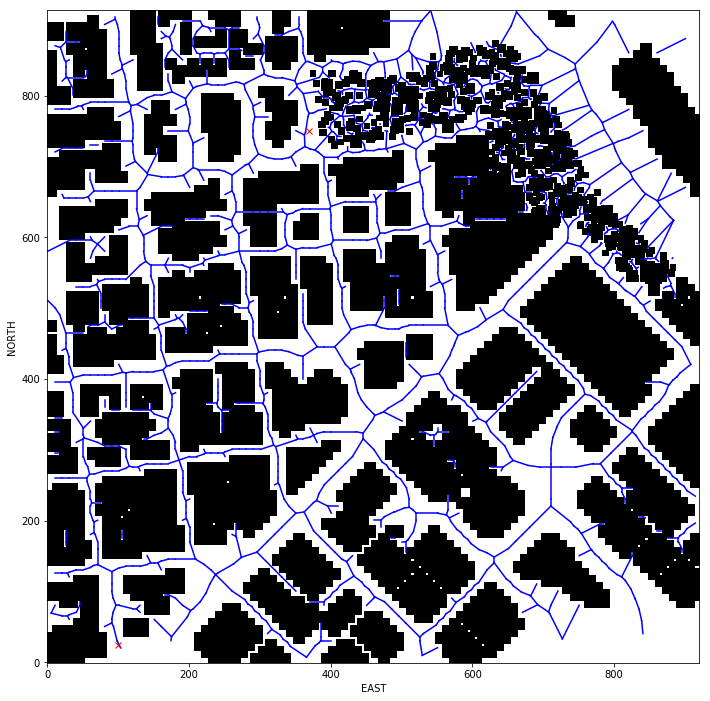

In [9]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
plt.imshow(grid, origin='lower', cmap='Greys') 

for e in edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')

    
plt.plot(start_ne[1], start_ne[0], 'rx')
plt.plot(goal_ne[1], goal_ne[0], 'rx')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

We now have a graph, well at least visually. The next step is to use the [`networkx`](https://networkx.github.io) to create the graph. **NetworkX** is a popular library handling anything and everything related to graph data structures and algorithms.

**NOTE:** In the initial import above it was imported with the `nx` alias.

You're encouraged to read the documentation but here's a super quick tour:

1. Create a graph:

```
G = nx.Graph()
```

2. Add an edge:

```
p1 = (10, 2.2)
p2 = (50, 40)
G = nx.add_edge(p1, p2)
```

3 Add an edge with a weight:

```
p1 = (10, 2.2)
p2 = (50, 40)
dist = LA.norm(np.array(p2) - np.array(p1))
G = nx.add_edge(p1, p2, weight=dist)
```

In [10]:
# TODO: create the graph with the weight of the edges
# set to the Euclidean distance between the points
G = nx.Graph()
for p1, p2 in edges:
    dist = LA.norm(np.array(p2) - np.array(p1))
    G.add_edge(p1, p2, weight=dist)

for n in G.nodes:
    print('Node:', n)
    print(G[n])
    print('Neighbors:')
    for a in G.neighbors(n):
        print(a)
        print(G.get_edge_data(n, a))
    print('----')   

Node: (860.7611, 860.7685)
{(880.7611, 900.7685): {'weight': 44.721359549995796}}
Neighbors:
(880.7611, 900.7685)
{'weight': 44.721359549995796}
----
Node: (880.7611, 900.7685)
{(860.7611, 860.7685): {'weight': 44.721359549995796}}
Neighbors:
(860.7611, 860.7685)
{'weight': 44.721359549995796}
----
Node: (905.1728647058824, 797.8273235294118)
{(875.7611, 775.7685): {'weight': 36.76470588235295}, (900.7611, 800.7685): {'weight': 5.3022812874469825}}
Neighbors:
(875.7611, 775.7685)
{'weight': 36.76470588235295}
(900.7611, 800.7685)
{'weight': 5.3022812874469825}
----
Node: (875.7611, 775.7685)
{(905.1728647058824, 797.8273235294118): {'weight': 36.76470588235295}, (845.0918815402507, 745.0992815402507): {'weight': 43.37282469316081}}
Neighbors:
(905.1728647058824, 797.8273235294118)
{'weight': 36.76470588235295}
(845.0918815402507, 745.0992815402507)
{'weight': 43.37282469316081}
----
Node: (845.0918815402507, 745.0992815402507)
{(875.7611, 775.7685): {'weight': 43.37282469316081}, (853.

(860.7611, 240.7685)
{'weight': 5.270462766947287}
----
Node: (860.7611, 250.76850000000002)
{(850.7611, 255.76850000000002): {'weight': 11.180339887498949}, (860.7611, 240.7685): {'weight': 10.000000000000028}, (865.7611, 255.76850000000002): {'weight': 7.0710678118654755}}
Neighbors:
(850.7611, 255.76850000000002)
{'weight': 11.180339887498949}
(860.7611, 240.7685)
{'weight': 10.000000000000028}
(865.7611, 255.76850000000002)
{'weight': 7.0710678118654755}
----
Node: (850.7611, 255.76850000000002)
{(860.7611, 250.76850000000002): {'weight': 11.180339887498949}, (840.7611, 255.76850000000002): {'weight': 10.0}}
Neighbors:
(860.7611, 250.76850000000002)
{'weight': 11.180339887498949}
(840.7611, 255.76850000000002)
{'weight': 10.0}
----
Node: (860.7611, 240.7685)
{(860.7611, 250.76850000000002): {'weight': 10.000000000000028}, (859.0944333333334, 235.7685): {'weight': 5.270462766947287}}
Neighbors:
(860.7611, 250.76850000000002)
{'weight': 10.000000000000028}
(859.0944333333334, 235.768

{'weight': 10.0}
----
Node: (470.04681505102064, 428.6256033673471)
{(474.0944348999997, 440.76846595): {'weight': 12.799700705213457}, (490.7611, 418.26846218750006): {'weight': 23.15927404662753}, (465.7610962799992, 425.7684575199995): {'weight': 5.150792927045401}}
Neighbors:
(474.0944348999997, 440.76846595)
{'weight': 12.799700705213457}
(490.7611, 418.26846218750006)
{'weight': 23.15927404662753}
(465.7610962799992, 425.7684575199995)
{'weight': 5.150792927045401}
----
Node: (474.0944348999997, 440.76846595)
{(470.04681505102064, 428.6256033673471): {'weight': 12.799700705213457}, (475.76110083333276, 450.76846845): {'weight': 10.137939895922594}}
Neighbors:
(470.04681505102064, 428.6256033673471)
{'weight': 12.799700705213457}
(475.76110083333276, 450.76846845)
{'weight': 10.137939895922594}
----
Node: (490.7611, 418.26846218750006)
{(470.04681505102064, 428.6256033673471): {'weight': 23.15927404662753}, (500.7611, 415.7684625): {'weight': 10.30776398825179}}
Neighbors:
(470.04

(773.1628028826287, 454.67752097374705)
{'weight': 2.3513604644369033}
(768.9313096899979, 452.08055554476425)
{'weight': 2.8912743627580886}
----
Node: (790.2082031757095, 439.4989334231487)
{(791.4599575829882, 444.9266792899222): {'weight': 5.570216718442718}, (791.8840603441948, 432.99447536515004): {'weight': 6.716879623562356}}
Neighbors:
(791.4599575829882, 444.9266792899222)
{'weight': 5.570216718442718}
(791.8840603441948, 432.99447536515004)
{'weight': 6.716879623562356}
----
Node: (828.2610999999999, 310.7685)
{(825.7610999999999, 320.7685): {'weight': 10.307764064044152}, (830.7610999999999, 305.7685): {'weight': 5.5901699437494745}}
Neighbors:
(825.7610999999999, 320.7685)
{'weight': 10.307764064044152}
(830.7610999999999, 305.7685)
{'weight': 5.5901699437494745}
----
Node: (825.7610999999999, 320.7685)
{(828.2610999999999, 310.7685): {'weight': 10.307764064044152}, (825.7610999999999, 330.7685): {'weight': 10.0}}
Neighbors:
(828.2610999999999, 310.7685)
{'weight': 10.3077

{'weight': 8.38021420933979}
(679.9099533887032, 744.8046528970184)
{'weight': 5.357510994112646}
(669.4177204050102, 744.068432940011)
{'weight': 7.90845854924186}
----
Node: (691.8812517348466, 740.2873810872758)
{(693.4863657699111, 742.580337771464): {'weight': 2.7989357658089236}, (691.5209847885686, 734.8730820810969): {'weight': 5.426271832565189}}
Neighbors:
(693.4863657699111, 742.580337771464)
{'weight': 2.7989357658089236}
(691.5209847885686, 734.8730820810969)
{'weight': 5.426271832565189}
----
Node: (679.9099533887032, 744.8046528970184)
{(675.9941058460689, 748.4610257000683): {'weight': 5.357510994112646}}
Neighbors:
(675.9941058460689, 748.4610257000683)
{'weight': 5.357510994112646}
----
Node: (691.5209847885686, 734.8730820810969)
{(691.8812517348466, 740.2873810872758): {'weight': 5.426271832565189}, (685.715218800709, 726.7478220204674): {'weight': 9.986329143316286}}
Neighbors:
(691.8812517348466, 740.2873810872758)
{'weight': 5.426271832565189}
(685.715218800709, 

{'weight': 20.32892781536818}
----
Node: (630.7610999999999, 230.7685)
{(630.7610999999999, 240.7685): {'weight': 10.0}}
Neighbors:
(630.7610999999999, 240.7685)
{'weight': 10.0}
----
Node: (624.3325285714285, 260.0542142857143)
{(630.7610999999999, 240.7685): {'weight': 20.32892781536818}, (616.2157384299474, 261.67757231401055): {'weight': 8.277534263829986}, (635.7610999999999, 265.7685): {'weight': 12.777531299998817}}
Neighbors:
(630.7610999999999, 240.7685)
{'weight': 20.32892781536818}
(616.2157384299474, 261.67757231401055)
{'weight': 8.277534263829986}
(635.7610999999999, 265.7685)
{'weight': 12.777531299998817}
----
Node: (616.2157384299474, 261.67757231401055)
{(624.3325285714285, 260.0542142857143): {'weight': 8.277534263829986}, (610.7610999999999, 250.76835000050002): {'weight': 12.196893534300242}, (605.3065632231029, 269.8594264462059): {'weight': 13.636452644810213}}
Neighbors:
(624.3325285714285, 260.0542142857143)
{'weight': 8.277534263829986}
(610.7610999999999, 250

Node: (821.6985981436612, 641.1481996102845)
{(816.6235308264323, 627.5620452441732): {'weight': 14.50309962505288}, (828.5686850145875, 645.6641193229868): {'weight': 8.221412559022138}}
Neighbors:
(816.6235308264323, 627.5620452441732)
{'weight': 14.50309962505288}
(828.5686850145875, 645.6641193229868)
{'weight': 8.221412559022138}
----
Node: (708.88926044717, 741.7385909495189)
{(709.2472778610831, 741.3863561896175): {'weight': 0.5022407736811478}}
Neighbors:
(709.2472778610831, 741.3863561896175)
{'weight': 0.5022407736811478}
----
Node: (709.2472778610831, 741.3863561896175)
{(708.88926044717, 741.7385909495189): {'weight': 0.5022407736811478}}
Neighbors:
(708.88926044717, 741.7385909495189)
{'weight': 0.5022407736811478}
----
Node: (716.7983698079411, 725.6310089670604)
{(712.2545346772695, 725.418995908167): {'weight': 4.548778652766776}}
Neighbors:
(712.2545346772695, 725.418995908167)
{'weight': 4.548778652766776}
----
Node: (712.2545346772695, 725.418995908167)
{(716.798369

{(355.76114, 100.76850000000002): {'weight': 10.0}}
Neighbors:
(355.76114, 100.76850000000002)
{'weight': 10.0}
----
Node: (360.76114, 307.4351666666667)
{(364.76114, 304.7685): {'weight': 4.807401700618663}, (350.76114, 310.7685): {'weight': 10.540925533894592}}
Neighbors:
(364.76114, 304.7685)
{'weight': 4.807401700618663}
(350.76114, 310.7685)
{'weight': 10.540925533894592}
----
Node: (350.76114, 310.7685)
{(340.76128499935004, 310.7685): {'weight': 9.999855000649973}, (360.76114, 307.4351666666667): {'weight': 10.540925533894592}}
Neighbors:
(340.76128499935004, 310.7685)
{'weight': 9.999855000649973}
(360.76114, 307.4351666666667)
{'weight': 10.540925533894592}
----
Node: (295.76113945, 230.7685)
{(295.76113945, 240.7685): {'weight': 10.0}, (295.76113945, 223.26849917499996): {'weight': 7.500000825000029}}
Neighbors:
(295.76113945, 240.7685)
{'weight': 10.0}
(295.76113945, 223.26849917499996)
{'weight': 7.500000825000029}
----
Node: (295.76113945, 240.7685)
{(295.76113945, 230.768

Node: (70.7611, 670.7685)
{(81.47538571428571, 692.1970714285715): {'weight': 23.95787118749776}}
Neighbors:
(81.47538571428571, 692.1970714285715)
{'weight': 23.95787118749776}
----
Node: (71.21564545454545, 707.5866818181819)
{(81.47538571428571, 692.1970714285715): {'weight': 18.496009789717895}, (69.09443333333333, 709.1018333333334): {'weight': 2.6067652324371546}, (80.7611, 710.7685): {'weight': 10.061792555081192}}
Neighbors:
(81.47538571428571, 692.1970714285715)
{'weight': 18.496009789717895}
(69.09443333333333, 709.1018333333334)
{'weight': 2.6067652324371546}
(80.7611, 710.7685)
{'weight': 10.061792555081192}
----
Node: (170.76100625066408, 660.7683437503985)
{(180.76111874996093, 670.768481250039): {'weight': 14.142312399685938}, (170.76100624933596, 660.7683437496016): {'weight': 1.5488180320633894e-09}}
Neighbors:
(180.76111874996093, 670.768481250039)
{'weight': 14.142312399685938}
(170.76100624933596, 660.7683437496016)
{'weight': 1.5488180320633894e-09}
----
Node: (103

{'weight': 5.0}
----
Node: (58.7611, 308.7685)
{(46.7611, 316.7685): {'weight': 14.422205101855956}, (62.7611, 302.7685): {'weight': 7.211102550927978}}
Neighbors:
(46.7611, 316.7685)
{'weight': 14.422205101855956}
(62.7611, 302.7685)
{'weight': 7.211102550927978}
----
Node: (46.7611, 316.7685)
{(58.7611, 308.7685): {'weight': 14.422205101855956}, (46.761095999796, 316.768501000051): {'weight': 4.123315901517851e-06}}
Neighbors:
(58.7611, 308.7685)
{'weight': 14.422205101855956}
(46.761095999796, 316.768501000051)
{'weight': 4.123315901517851e-06}
----
Node: (38.76110120010849, 328.7684331999213)
{(32.761157599676466, 332.7683876003005): {'weight': 7.211030329535332}, (46.761095999796, 316.768501000051): {'weight': 14.422145804162104}}
Neighbors:
(32.761157599676466, 332.7683876003005)
{'weight': 7.211030329535332}
(46.761095999796, 316.768501000051)
{'weight': 14.422145804162104}
----
Node: (46.761095999796, 316.768501000051)
{(38.76110120010849, 328.7684331999213): {'weight': 14.4221

You need a method to search the graph, and you'll adapt A* in order to do this. The notable differences being the actions are now the outgoing edges and the cost of an action is that weight of that edge.

In [11]:
from queue import PriorityQueue

def heuristic(n1, n2):
    return LA.norm(np.array(n1) - np.array(n2))

###### THIS IS YOUR OLD GRID-BASED A* IMPLEMENTATION #######
###### With a few minor modifications it can work with graphs! ####
#TODO: modify A* to work with a graph
def a_star(graph, h, start, goal):

    path = []
    path_cost = 0
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_node = item[1]
        if current_node == start:
            current_cost = 0.0
        else:              
            current_cost = branch[current_node][0]
            
        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for next_node in graph.neighbors(current_node):
                branch_cost = current_cost + graph.get_edge_data(current_node,next_node)['weight']
                queue_cost = branch_cost + h(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)               
                    branch[next_node] = (branch_cost, current_node)
                    queue.put((queue_cost, next_node))
             
    if found:
        # retrace steps
        n = goal
        path_cost = branch[n][0]
        path.append(goal)
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
    else:
        print('**********************')
        print('Failed to find a path!')
        print('**********************') 
    return path[::-1], path_cost


### Solution

This solution consists of two parts:

1. Find the closest point in the graph to our current location, same thing for the goal location.
2. Compute the path from the two points in the graph using the A* algorithm.
3. Feel free to use any of the path pruning techniques to make the path even smaller! 
4. Plot it up to see the results!

### TODO: Write your solution!

[our solution](/notebooks/Graph-Search-Solution.ipynb)

In [12]:
def find_nearest_node(graph, pos):
    # Find the nearest node on the graph to the
    # specified position
    
    # Generate an array of all node positions
    nodes = np.array(graph.nodes)

    # Calculate the distance of all nodes to the specified position
    dist = LA.norm(nodes - np.array(pos), axis=1)
    # Find the index of the minimum distance element and get the
    # node position
    near_node = nodes[dist.argmin()]
    
    return tuple(near_node)

graph_start = find_nearest_node(G, start_ne)
graph_goal = find_nearest_node(G, goal_ne)

print(start_ne, goal_ne)
print(graph_start, graph_goal)


(25, 100) (750.0, 370.0)
(20.7611, 103.26850000000002) (748.7187188843021, 364.4144680930903)


Found a path.
Path found of length 97. Total cost: 1050.2941022437396


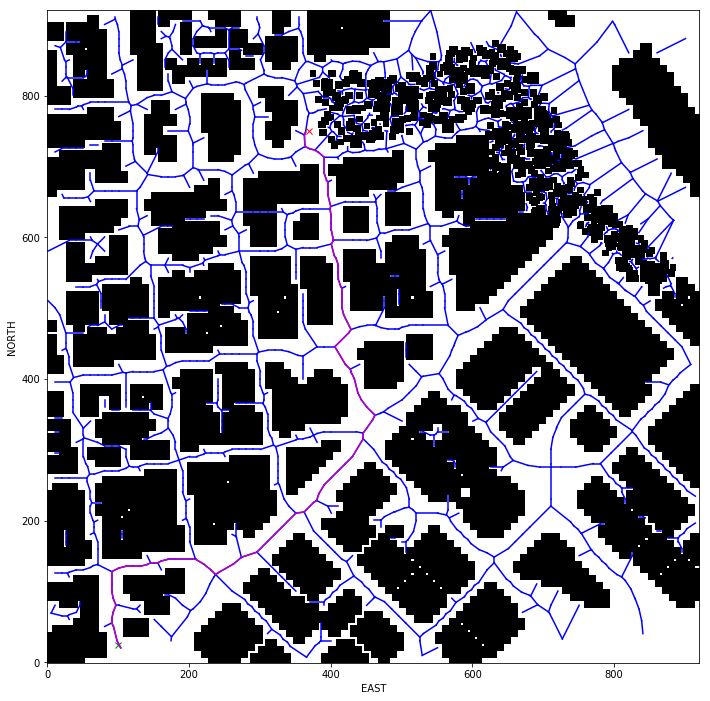

In [13]:
# 1a. Find the closest point in the graph to the start location:
graph_start = find_nearest_node(G, start_ne)

# 1b. Find the closest point in the graph to the goal location:
graph_goal = find_nearest_node(G, goal_ne)

# 2. Compute the path from the two points in the graph using the A* algorithm.
path, path_cost = a_star(G, heuristic, graph_start, graph_goal)
print("Path found of length {0}. Total cost: {1}".format(len(path), path_cost))

# 3. Feel free to use any of the path pruning techniques to make the path even smaller! 
# TODO: Prune path using bresenham?

# 4. Plot it up to see the results!
plt.imshow(grid, cmap='Greys', origin='lower')

for e in edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')

# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(start_ne[1], start_ne[0], 'gx')
# Uncomment the following as needed
plt.plot(goal_ne[1], goal_ne[0], 'rx')

pp = np.array(path)
plt.plot(pp[:, 1], pp[:, 0], 'm')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()